In [ ]:
# default_exp animations

# Animations
> This module contains the utilities needed to generate animations of how an `optimize` object progresses on a given `Ifunction` surface. This supports both `derivative-based` (like `SGD`, `Adam`, etc..) or `derivative-free` optimization methods

In [ ]:
#exporti
import matplotlib.animation as animation
from matplotlib import pyplot as plt
from IPython.display import HTML, display
from itertools import cycle
from typing import List, Union
from cycler import cycler
from functools import partial
from mpl_toolkits.mplot3d.art3d import Line3D, Poly3DCollection
import numpy as np
from itertools import islice

from optimisations.graphics import plot_function
from optimisations.graphics import rotate
from optimisations.optimizers import optimize

interactive(children=(IntSlider(value=45, description='azimuth', max=135, min=-45), IntSlider(value=45, descri…

In [ ]:
#exports
class Figure:
    def __init__(self, fig=None, ax_3d=None, ax_2d=None, angle=225, contour_log_scale=True, legend_location="upper right", azimuth_3d=30, zoom_factor=0, force_line_zorder=True):
        self.fig = fig
        self.ax_3d = ax_3d
        self.ax_2d = ax_2d
        self.angle = angle
        self.contour_log_scale = contour_log_scale
        self.legend_location = legend_location
        self.azimuth_3d = azimuth_3d
        self.zoom_factor = zoom_factor
        self.force_line_zorder = force_line_zorder

A `Figure` object is the main datastructure that encapsulates a all the elements and settings of a plot

In [ ]:
#exporti
from itertools import cycle
from typing import List
from functools import partial
from mpl_toolkits.mplot3d.art3d import Line3D, Poly3DCollection

class FixZorderLine3D(Line3D):
    @property
    def zorder(self):
        return 1000

    @zorder.setter
    def zorder(self, value):
        pass

In [ ]:
#exporti
def nth(iterable, n, default=None):
    """
    Returns the nth item or a default value
    """
    return next(islice(iterable, n, None), default)

In [ ]:
#export
color_cycles = 'bgrcmyk'

def decorate_with_derivative_based_plot(_id, optimisation, figure: Figure):
    """
    Decorates the given figure with the illustration of the progress made so far
    by the given optimiser. This function also increments one step into the optimisation process.  

    Note: This decorating function should be used for derivative based optimisers as it only draws
    a single point for each time-step. Other optimisers could be displayed diffrently.
    """
    history = optimisation.update()  # maybe do this outisde and only access `optimisation.history`
    coords = np.array([np.asarray(optimisation._get_params(state)) for state in history])
    x, y = list(zip(*coords))
    x, y = np.array(x), np.array(y)

    label = optimisation.optimizer_name

    #choose the color of this optimisere based on the _id number (should be the same every time, for the same optimiser) 
    color = nth(cycle(color_cycles), _id)

    # draw the line paths
    figure.ax_2d.plot(*rotate(x, y, angle=figure.angle), color=color, label=label)
    lines = figure.ax_3d.plot3D(x, y, optimisation.function(x, y), color=color, label=label)
    
    # force the lines to be drawn on top (for the 3D plot)
    if figure.force_line_zorder:
        for line in lines:
            line.__class__ = FixZorderLine3D

    #draw the last points
    figure.ax_2d.scatter(*rotate(x[-1:], y[-1:], angle=figure.angle), color=color)
    figure.ax_3d.scatter3D(x[-1:], y[-1:], optimisation.function(x[-1:], y[-1:]), color=color)

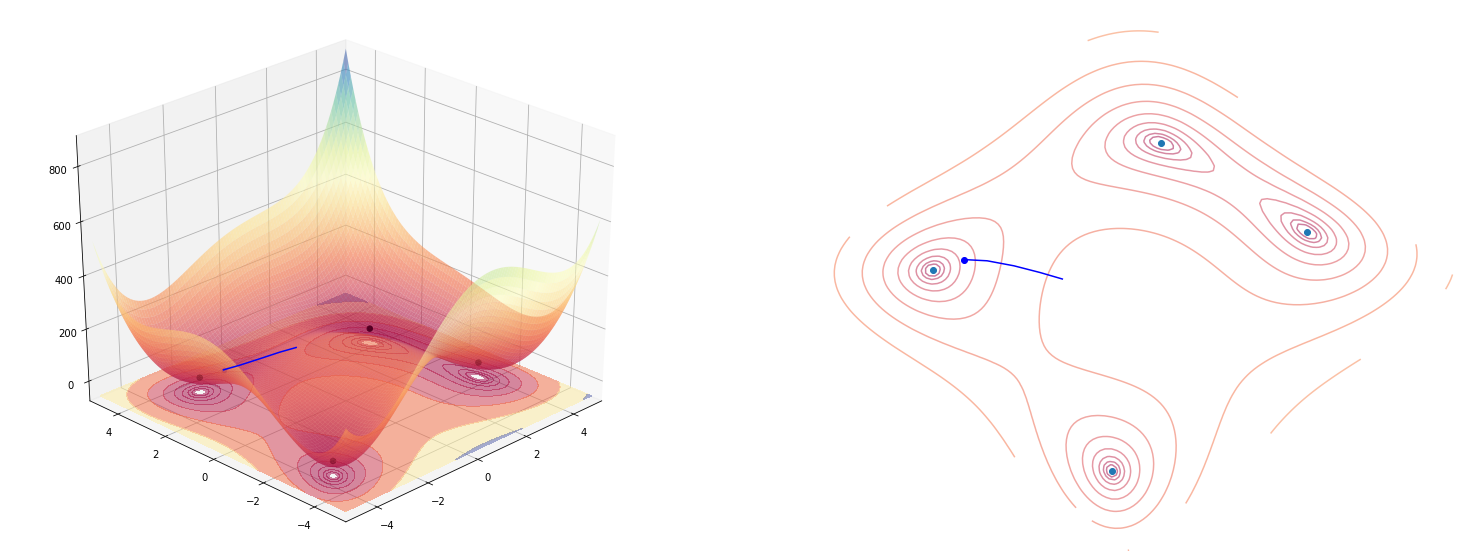

In [ ]:
from jax.experimental.optimizers import sgd
from optimisations.functions import himmelblau
from optimisations.optimizers import optimize

figure = Figure()
figure.fig, figure.ax_3d, figure.ax_2d = plot_function(himmelblau(), fig=figure.fig, angle=figure.angle, contour_log_scale=figure.contour_log_scale, zoom_factor=figure.zoom_factor)

optimisation = (
    optimize(himmelblau())
        .using(sgd(step_size=0.01), name="sdg")
        .start_from([-1., 1.])
) 
optimisation.update(3)
    
decorate_with_derivative_based_plot(
    0,
    optimisation,
    figure
)

In [ ]:
#export
renderers = {
    'sgd': decorate_with_derivative_based_plot,
    'rmsprop': decorate_with_derivative_based_plot,
    'adamax': decorate_with_derivative_based_plot,
    'adam': decorate_with_derivative_based_plot,
    'momentum': decorate_with_derivative_based_plot,
#     'ga': decorate_with_genetic_algo_plot
}


def single_frame(i, optimisations: Union[optimize, List[optimize]], figure: Figure, renderers: dict):
    # make sure we have a list of optimizers going forward
    optimisations = [optimisations] if isinstance(optimisations, optimize) else optimisations

    figure.ax_3d.clear()
    figure.ax_2d.clear()
    
    assert len(optimisations) >= 1, f"We need at least one optimisation to animate, but {len(optimisations)} given."
    # assert all functions to optimise have the same definition

    plot_function(optimisations[0].function, angle=figure.angle, fig=figure.fig, ax_3d=figure.ax_3d, ax_2d=figure.ax_2d, contour_log_scale=figure.contour_log_scale, azimuth_3d=figure.azimuth_3d, zoom_factor=figure.zoom_factor)
    
    for i, optimisation in enumerate(optimisations):
        if optimisation.optimizer_name not in renderers and i <= 1:  # only show this error once
            print(f"Couldn't find a propper renderer for function named {optimisation.optimizer_name}. Will try to use the default `decorate_with_derivative_based_plot` method.")
        renderer = renderers.get(optimisation.optimizer_name, decorate_with_derivative_based_plot)
        
        renderer(i, optimisation, figure)

    # add a legend to the chart
    figure.ax_2d.legend(loc=figure.legend_location)

    # add a credits watermark such as not to overlap with the legend
    if figure.legend_location == "upper right":
        figure.ax_2d.text(1, 0, 'www.clungu.com', transform=figure.ax_2d.transAxes, ha='right',
                color='#777777', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
    else:
        figure.ax_2d.text(1, 1, 'www.clungu.com', transform=figure.ax_2d.transAxes, ha='right',
                color='#777777', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))


    figure.ax_2d.plot()
    print(".", end ="")

.

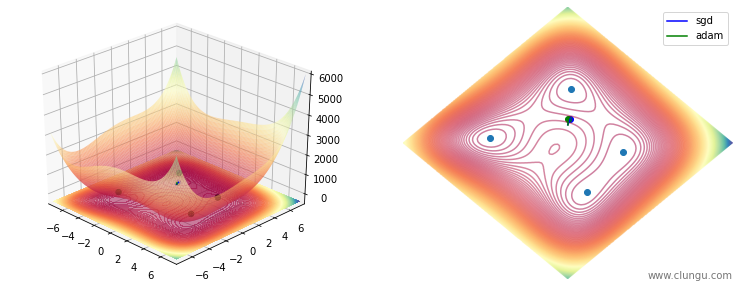

In [ ]:
from optimisations.optimizers import optimize_multi
from jax.experimental.optimizers import adam

function = himmelblau()

figure=Figure(
    fig=plt.figure(figsize=(13,5)), 
    contour_log_scale=False, 
    angle=45-90, 
    zoom_factor=-0.5
)
figure.fig, figure.ax_3d, figure.ax_2d = plot_function(function, fig=figure.fig, angle=figure.angle, contour_log_scale=figure.contour_log_scale, zoom_factor=figure.zoom_factor)


single_frame(
    0,
    optimize_multi(function)
        .using([
            (sgd(step_size=0.01), "sgd", True),
            (adam(step_size=0.3), "adam", True),
        ])
        .start_from([-1., 1.])
        .tolist(),
    figure=figure,
    renderers=renderers
);

In [ ]:
#export
def animate(optimisations: Union[optimize, List[optimize]], figure: Figure=None, renderers=renderers, frames=20, interval=50, output='mp4'):
    optimisations = [optimisations] if isinstance(optimisations, optimize) else optimisations

    assert len(optimisations) >= 1, f"We need at least one optimisation to animate, but {len(optimisations)} given."
    
    if figure is None:
        figure=Figure(
            fig=plt.figure(figsize=(13,5)), 
            contour_log_scale=False, 
            angle=45,
        )
        
    figure.fig, figure.ax_3d, figure.ax_2d = plot_function(optimisations[0].function, fig=figure.fig, angle=figure.angle, contour_log_scale=figure.contour_log_scale, zoom_factor=figure.zoom_factor)
    figure.fig.tight_layout()

    animator = animation.FuncAnimation(figure.fig, partial(single_frame, figure=figure, renderers=renderers), fargs=(optimisations,), frames=frames, interval=interval, blit=False)
    
    if output == 'mp4':
        video = animator.to_html5_video()
    elif output == 'js':
        video = animator.to_jshtml()
    else:
        raise ValueError(f"Provided output type {output} is unknown. Use one of 'mp4' or 'js'")
    
    display(HTML(video))
    plt.close()

    return video

> Warning: The generation of the function is quite slow, as it doesn't use the `matplotlib`s `set_data` &co functions. For simplicity it generates new plots for each new frame. Since this is not intended to be used in real time, this is good enough for once-in-a-while generation.

In [ ]:
from jax.experimental.optimizers import sgd

animate(
    optimize_multi(himmelblau())
        .using([
            (sgd(step_size=0.01), "sgd", True),
            (adam(step_size=0.3), "adam", True),
        ])
        .start_from([-1., 1.])
        .tolist(),
    frames=20,
    interval=50,
    figure=Figure(
        fig=plt.figure(figsize=(13,5)), 
        contour_log_scale=False, 
        angle=45-90, 
        zoom_factor=-0.5
    )
);

.....................

## Usage examples

Basic usage of the `animation` function for a single `optimize` object (in this case `JAX`s `sgd` implementation)

In [ ]:
from jax.experimental.optimizers import sgd, adam
from optimisations.functions import saddle_point
from optimisations.optimizers import optimize_multi

animate(
    optimize(saddle_point())
        .using(sgd(step_size=0.3), name="sgd", derivatives_based=True)
        .start_from([0.0003, 0.01]),
    frames=7
);

........

Usage for a concurrent optimization animation

In [ ]:
from jax.experimental.optimizers import sgd, adam, rmsprop, adagrad, nesterov

animate(
    optimize_multi(saddle_point())
        .using([
            (sgd(step_size=0.1), "sgd", True),
            (adam(step_size=0.01), "adam", True),
            (rmsprop(step_size=0.01), "rmsprop", True),
            (adagrad(step_size=0.1), "adagrad", True),
            (nesterov(mass=0.1, step_size=0.1), "nesterov", True),
        ])
        .start_from([-0.0003, -0.01])
        .tolist(),
    frames=10,
    interval=50,
    figure=Figure(
        fig=plt.figure(figsize=(13,5)), 
        contour_log_scale=False,
    )
);

...........